foward path에서 위치 정보를 저장해놓고 있다가 switches(값을 넘겨줘서) deconvolution을 해서 복원을 해서 visualization해서 보여주는 것

처음의 input image로 돌아가면, 특정 필터가 input image의 어떤 부분이 feature map을 크게 만들었는지(자극했는지) 알 수 있다.

->CNN이 얼마나 잘 학습되고있는가를 확인하는 기술이다. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
import time

CIFAR-10 is an established CV dataset used for object recognition.

It is a subset of the 80 million tiny images dataset and consists of 6만개 32x32 color images containing one of 10 objcet classes, 클래스마다 6천개 image.

In [2]:
(x_train, y_train), (x_test, y_test)  = keras.datasets.cifar10.load_data()
# 튜플 형태로 데이터를 받아온다.

170508288/170498071 [==============================] - 13s 0us/step


In [3]:
print ("Training data:")
print ("Number of examples: ", x_train.shape[0])
print ("Number of channels:",x_train.shape[3]) 
print ("Image size:", x_train.shape[1], x_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", x_test.shape[0])
print ("Number of channels:", x_test.shape[3])
print ("Image size:", x_test.shape[1], x_test.shape[2])

Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


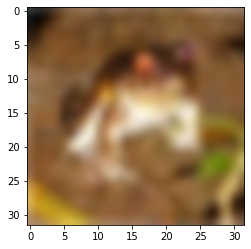

In [4]:
plt.imshow(x_train[0], interpolation="bicubic")

이미지 품질 자체가 blur한 상태를 확인할 수 있다.

In [5]:
y_train.shape

(50000, 1)

In [6]:
num_classes = 10
y_train = np_utils.to_categorical(y_train) # one-hot vector로 표현하기 위해서 to_categorical함수를 사용
y_test = np_utils.to_categorical(y_test)

In [7]:
y_train.shape

(50000, 10)

test용의 데이터를 split하기 위해서 설정해주었다.

In [8]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [9]:
train_images.shape

(49500, 32, 32, 3)

In [15]:
model = keras.models.Sequential([
    # input image의 크기가 작은데, 11x11conv, strides를 4x4할 필요가 있나? -> 좀 줄여서 진행!
    keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(32,32,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # overlapping pooling 진행한다.

    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    # padding = same을 통해서 output image를 동일하게 유지
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')

])

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 96)        2688      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_21 (Bat  (None, 14, 14, 256)      1024      
 chNormalization)                                                
                                                      

ImageDataGenerator에 대한 개념

https://keras.io/ko/preprocessing/image/

In [17]:
from keras.preprocessing.image import ImageDataGenerator
# 32x32 이미지 데이터 수만개를 한번의 노드를 이용해서 사용하려면 많은 메모리가 수요된다. 
# -> 메모리 활용에 비효율적이기 때문에 -> 메모리를 유동적으로 할당하고 해제하고 할 수 있게 

train_datagen = ImageDataGenerator(rescale = 1./255, # normalization
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

## ImageDataGenerator - flow함수를 쓰는 이유?

-> 실시간 데이터 증강을 사용해 배치에 대해서 모델을 학습

<사용방법>

flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None)


In [18]:
history = model.fit(train_datagen.flow(train_images,train_labels, batch_size = 32), 
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32),
                    epochs = 10)

Epoch 1/10
1547/1547 [==============================] - 50s 24ms/step - loss: 1.6442 - accuracy: 0.4308 - val_loss: 1.3171 - val_accuracy: 0.5140
Epoch 2/10
1547/1547 [==============================] - 38s 24ms/step - loss: 1.1849 - accuracy: 0.5879 - val_loss: 1.2574 - val_accuracy: 0.5500
Epoch 3/10
1547/1547 [==============================] - 36s 24ms/step - loss: 1.0077 - accuracy: 0.6569 - val_loss: 0.9805 - val_accuracy: 0.6480
Epoch 4/10
1547/1547 [==============================] - 36s 23ms/step - loss: 0.8998 - accuracy: 0.6939 - val_loss: 1.0152 - val_accuracy: 0.6520
Epoch 5/10
1547/1547 [==============================] - 37s 24ms/step - loss: 0.8465 - accuracy: 0.7131 - val_loss: 0.9680 - val_accuracy: 0.6820
Epoch 6/10
1547/1547 [==============================] - 37s 24ms/step - loss: 0.7730 - accuracy: 0.7383 - val_loss: 0.7289 - val_accuracy: 0.7340
Epoch 7/10
1547/1547 [==============================] - 37s 24ms/step - loss: 0.7547 - accuracy: 0.7466 - val_loss: 0.7038 -

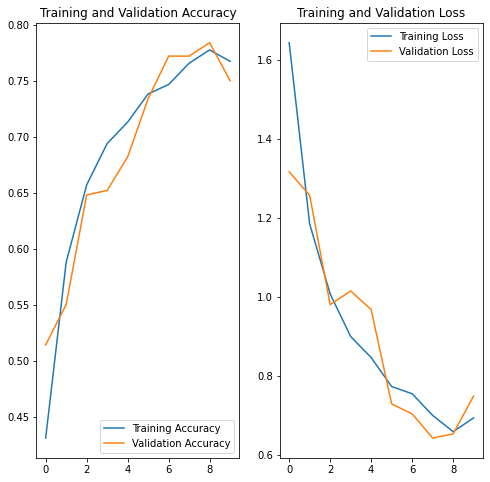

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

뭐 때문에 결과가 이렇게 튄건지 학습이 epoch =9,10부분에서 overfitting이 살짝 된 것을 볼 수 있다

-> why??? / epochs=20으로 설정하면 더 자세한 모습을 볼 수 있을 것으로 볼 수 있다.

그리고 이번 모델링을 진행할 때, 처음 convolution layer에서 커널 크기를 11x11에서 3x3으로 줄였고, strides = (1,1)로 줄이지않으면, 이미지가 얼마나 커져야지 써볼만할 가치가 있을지 궁금하다.